In [1]:
#Import the necessary libraries
import numpy as np
import pandas as pd
import os
import sys
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

2025-05-09 00:11:55.402201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746749515.662361      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746749515.729459      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Pre-Processing

In [2]:
#Reading the dataset. (Using kaggle notebook here.) As dataset is available on kaggle, going with kaggle.
file_path = '/kaggle/input/pizza-sales-dataset/pizza_sales.csv'
df = pd.read_csv(file_path)
df.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1.0,1.0,hawaiian_m,1.0,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2.0,2.0,classic_dlx_m,1.0,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3.0,2.0,five_cheese_l,1.0,1/1/2015,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4.0,2.0,ital_supr_l,1.0,1/1/2015,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5.0,2.0,mexicana_m,1.0,1/1/2015,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [3]:
#checking nulls in the data.
df.isnull().sum()

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

In [4]:
#basic structure of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  float64
 1   order_id           48620 non-null  float64
 2   pizza_name_id      48620 non-null  object 
 3   quantity           48620 non-null  float64
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48620 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48620 non-null  object 
 10  pizza_ingredients  48620 non-null  object 
 11  pizza_name         48620 non-null  object 
dtypes: float64(5), object(7)
memory usage: 4.5+ MB


In [5]:
#Listing out the columns and exploring the data.
print(df.columns)
print("\n")
print(df['quantity'].describe())
print("\n")
print(df['order_date'].describe())
print("\n")
print(df['total_price'].describe())
print("\n")
print(df['pizza_size'].describe())
print("\n")
print(df['pizza_category'].describe())
print("\n")
print(df['pizza_name'].describe())

Index(['pizza_id', 'order_id', 'pizza_name_id', 'quantity', 'order_date',
       'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients', 'pizza_name'],
      dtype='object')


count    48620.000000
mean         1.019622
std          0.143077
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: quantity, dtype: float64


count          48620
unique           358
top       26-11-2015
freq             261
Name: order_date, dtype: object


count    48620.000000
mean        16.821474
std          4.437398
min          9.750000
25%         12.750000
50%         16.500000
75%         20.500000
max         83.000000
Name: total_price, dtype: float64


count     48620
unique        5
top           L
freq      18526
Name: pizza_size, dtype: object


count       48620
unique          4
top       Classic
freq        14579
Name: pizza_category, dtype: object


count                        4

In [6]:
#Dropping the 'id' columns
df.drop(columns=["order_id","pizza_id","pizza_name_id"],inplace=True)

In [7]:
#Splitting up categorical columns (one-hot encoding)
df=pd.get_dummies(df,columns=["pizza_category"],drop_first=False)
df.head()

,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_ingredients,pizza_name,pizza_category_Chicken,pizza_category_Classic,pizza_category_Supreme,pizza_category_Veggie
0,1.0,1/1/2015,11:38:36,13.25,13.25,M,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,False,True,False,False
1,1.0,1/1/2015,11:57:40,16.00,16.00,M,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,False,True,False,False
2,1.0,1/1/2015,11:57:40,18.50,18.50,L,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,False,False,False,True
3,1.0,1/1/2015,11:57:40,20.75,20.75,L,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,False,False,True,False
4,1.0,1/1/2015,11:57:40,16.00,16.00,M,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,False,False,False,True


In [8]:
#Ensuring and explicitly setting the one-hot encoded blocks to [0,1] values
one_hot_columns = [col for col in df.columns if col.startswith('pizza_category')]
df[one_hot_columns] = df[one_hot_columns].astype(int)
df.head()

,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_ingredients,pizza_name,pizza_category_Chicken,pizza_category_Classic,pizza_category_Supreme,pizza_category_Veggie
0,1.0,1/1/2015,11:38:36,13.25,13.25,M,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,0,1,0,0
1,1.0,1/1/2015,11:57:40,16.00,16.00,M,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,0,1,0,0
2,1.0,1/1/2015,11:57:40,18.50,18.50,L,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,0,0,0,1
3,1.0,1/1/2015,11:57:40,20.75,20.75,L,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,0,0,1,0
4,1.0,1/1/2015,11:57:40,16.00,16.00,M,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,0,0,0,1


In [9]:
#label encoding the pizza_size column. (0 - small, 1 - medium ...) and drop original column.
le = LabelEncoder()
df['pizza_size_encoded'] = le.fit_transform(df['pizza_size'])
df.drop('pizza_size', axis=1, inplace=True)
df.head()

,quantity,order_date,order_time,unit_price,total_price,pizza_ingredients,pizza_name,pizza_category_Chicken,pizza_category_Classic,pizza_category_Supreme,pizza_category_Veggie,pizza_size_encoded
0,1.0,1/1/2015,11:38:36,13.25,13.25,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,0,1,0,0,1
1,1.0,1/1/2015,11:57:40,16.00,16.00,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,0,1,0,0,1
2,1.0,1/1/2015,11:57:40,18.50,18.50,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,0,0,0,1,0
3,1.0,1/1/2015,11:57:40,20.75,20.75,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,0,0,1,0,0
4,1.0,1/1/2015,11:57:40,16.00,16.00,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,0,0,0,1,1


In [10]:
#Date and time column handling
df['order_date'] = pd.to_datetime(df['order_date'], format='mixed', dayfirst=True)
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['day_of_week'] = df['order_date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['order_time'] = pd.to_datetime(df['order_time'], format='%H:%M:%S')
df.head()

,quantity,order_date,order_time,unit_price,total_price,pizza_ingredients,pizza_name,pizza_category_Chicken,pizza_category_Classic,pizza_category_Supreme,pizza_category_Veggie,pizza_size_encoded,year,month,day_of_week,is_weekend
0,1.0,2015-01-01,1900-01-01 11:38:36,13.25,13.25,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,0,1,0,0,1,2015,1,3,0
1,1.0,2015-01-01,1900-01-01 11:57:40,16.00,16.00,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,0,1,0,0,1,2015,1,3,0
2,1.0,2015-01-01,1900-01-01 11:57:40,18.50,18.50,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,0,0,0,1,0,2015,1,3,0
3,1.0,2015-01-01,1900-01-01 11:57:40,20.75,20.75,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,0,0,1,0,0,2015,1,3,0
4,1.0,2015-01-01,1900-01-01 11:57:40,16.00,16.00,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,0,0,0,1,1,2015,1,3,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   quantity                48620 non-null  float64       
 1   order_date              48620 non-null  datetime64[ns]
 2   order_time              48620 non-null  datetime64[ns]
 3   unit_price              48620 non-null  float64       
 4   total_price             48620 non-null  float64       
 5   pizza_ingredients       48620 non-null  object        
 6   pizza_name              48620 non-null  object        
 7   pizza_category_Chicken  48620 non-null  int64         
 8   pizza_category_Classic  48620 non-null  int64         
 9   pizza_category_Supreme  48620 non-null  int64         
 10  pizza_category_Veggie   48620 non-null  int64         
 11  pizza_size_encoded      48620 non-null  int64         
 12  year                    48620 non-null  int32 

# Exploratory Data Analysis

<Axes: title={'center': 'Daily Sales Trend'}, xlabel='order_date'>

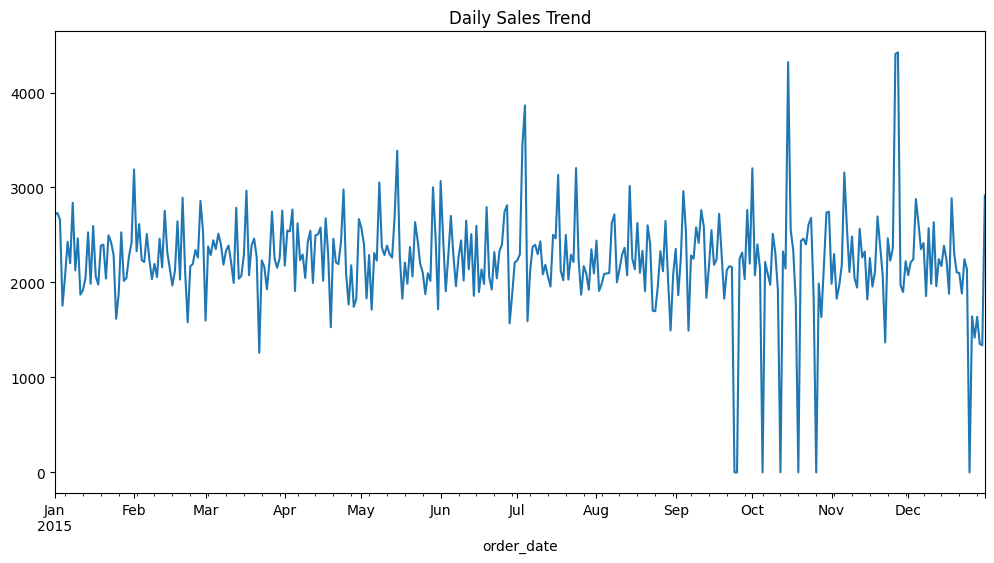

In [12]:
#Daily sales plot
df['order_date'] = pd.to_datetime(df['order_date'])
df.set_index('order_date', inplace=True)
df.resample('D')['total_price'].sum().plot(title='Daily Sales Trend', figsize=(12,6))

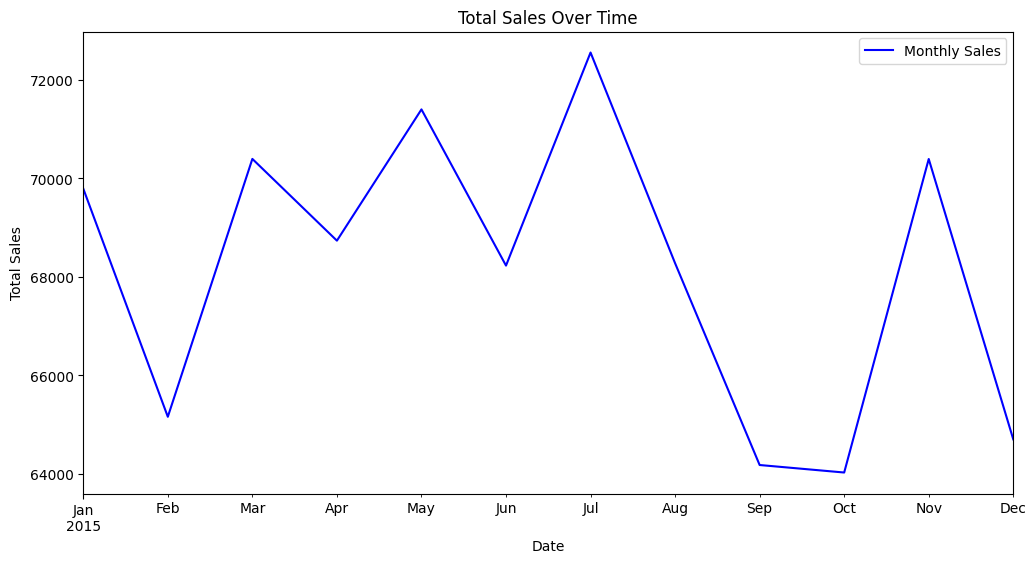

In [13]:
#Monthly sales plot
plt.figure(figsize=(12, 6))
df['total_price'].resample('ME').sum().plot(label='Monthly Sales', color='blue')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

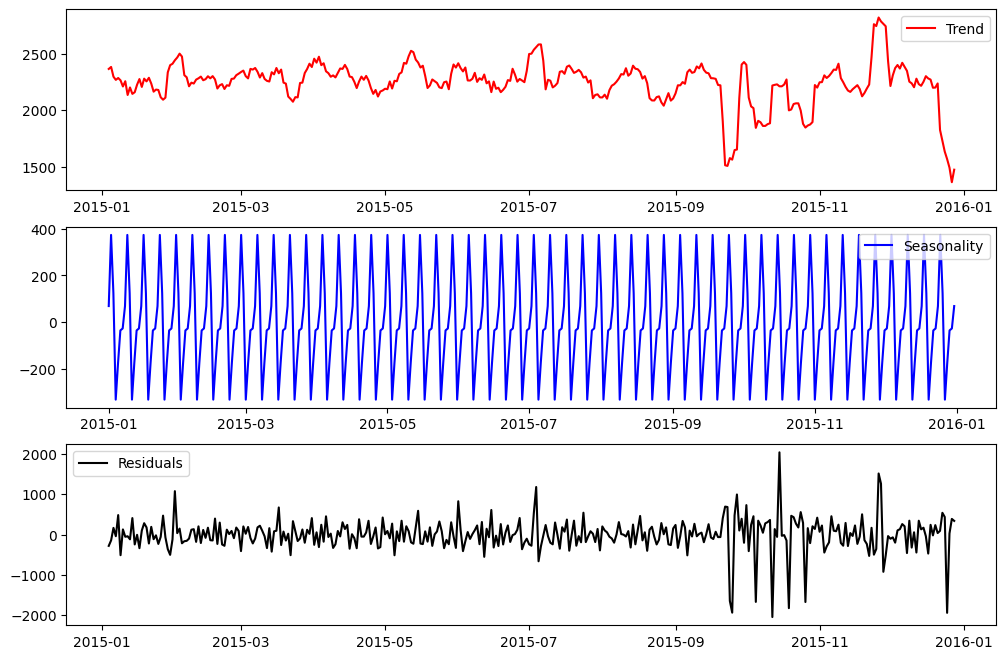

In [14]:
#plotting the trend, seasonal, and residual components
decomposed = seasonal_decompose(df['total_price'].resample('D').sum(), model='additive')

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(decomposed.trend, label='Trend', color='red')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(decomposed.seasonal, label='Seasonality', color='blue')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(decomposed.resid, label='Residuals', color='black')
plt.legend()

plt.show()

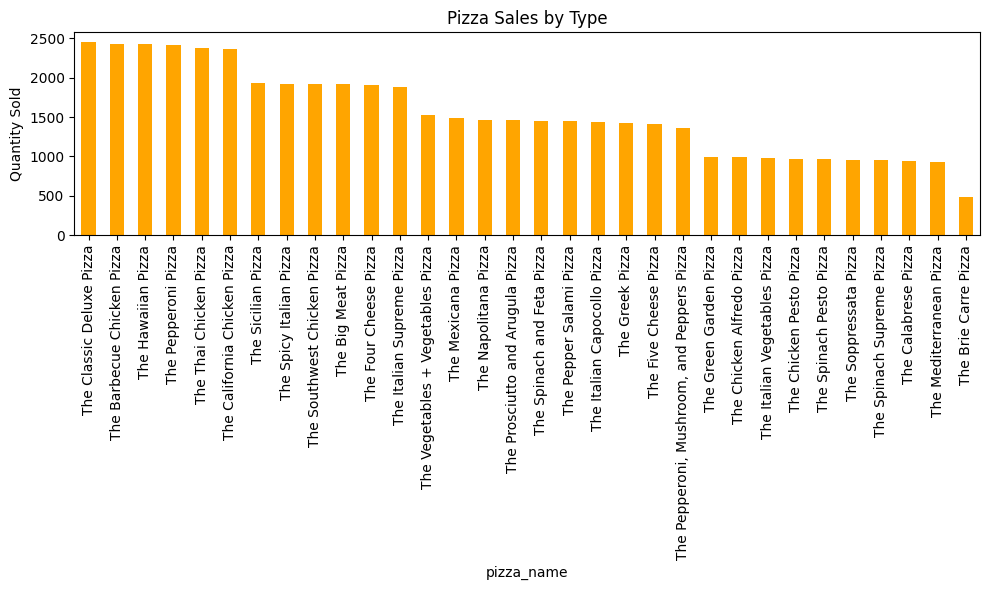

In [15]:
#plotting pizza names vs sales count
top_pizzas = df.groupby('pizza_name')['quantity'].sum().sort_values(ascending=False)
top_pizzas.plot(kind='bar', figsize=(10,6), color='orange')
plt.title('Pizza Sales by Type')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

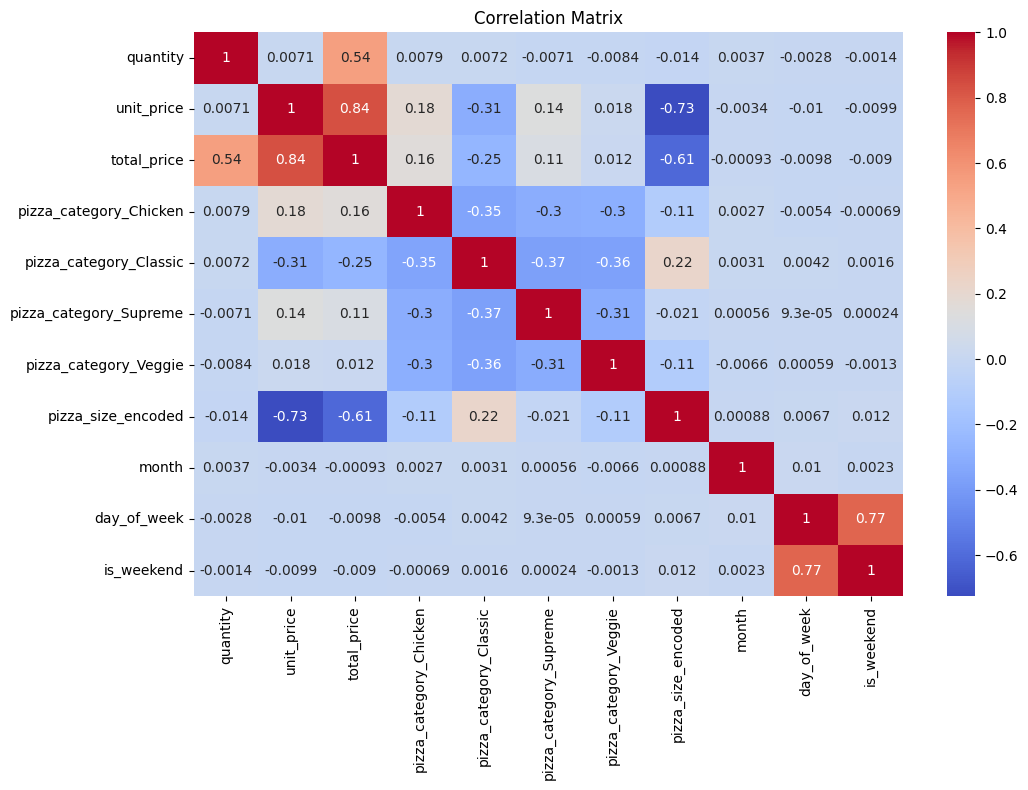

In [16]:
#correlation matrix
corr_cols = ['quantity', 'unit_price', 'total_price','pizza_category_Chicken', 'pizza_category_Classic', 'pizza_category_Supreme', 
             'pizza_category_Veggie', 'pizza_size_encoded', 'month', 'day_of_week', 'is_weekend']

corr = df[corr_cols].corr()

plt.figure(figsize=(11, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Data Preparation for Models

In [17]:
# Aggregating data into daily totals
daily_sales = df.resample('D')['total_price'].sum().reset_index()
daily_sales.columns = ['ds', 'y']

In [18]:
# Split data into train and test sets (80% train, 20% test)
train_size = int(len(daily_sales) * 0.8)
train_data = daily_sales[:train_size]
test_data = daily_sales[train_size:]

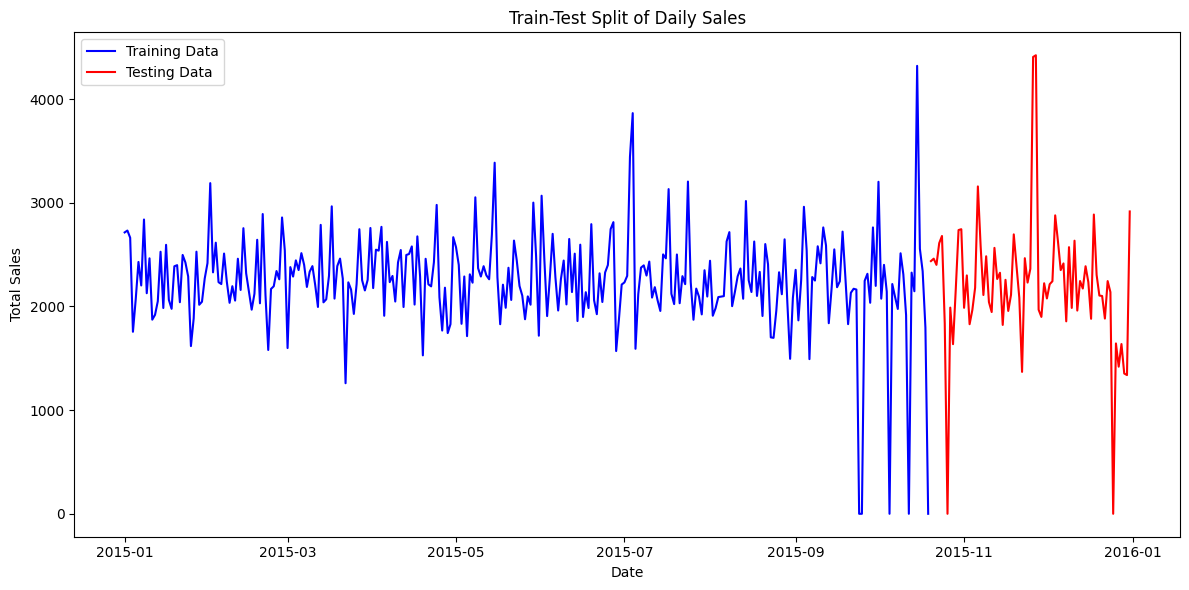

In [19]:
#Plotting the test-train split
plt.figure(figsize=(12, 6))
plt.plot(train_data['ds'], train_data['y'], label='Training Data', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Testing Data', color='red')
plt.title('Train-Test Split of Daily Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()

# Models
1. Prophet

In [20]:
#Initialize and train the model
model_prophet = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )
model_prophet.fit(train_data)

00:12:14 - cmdstanpy - INFO - Chain [1] start processing
00:12:14 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
#Make predictions and extract them
future = model_prophet.make_future_dataframe(periods=len(test_data))
forecast = model_prophet.predict(future)
prophet_predictions = forecast.loc[forecast['ds'].isin(test_data['ds'])]['yhat'].values

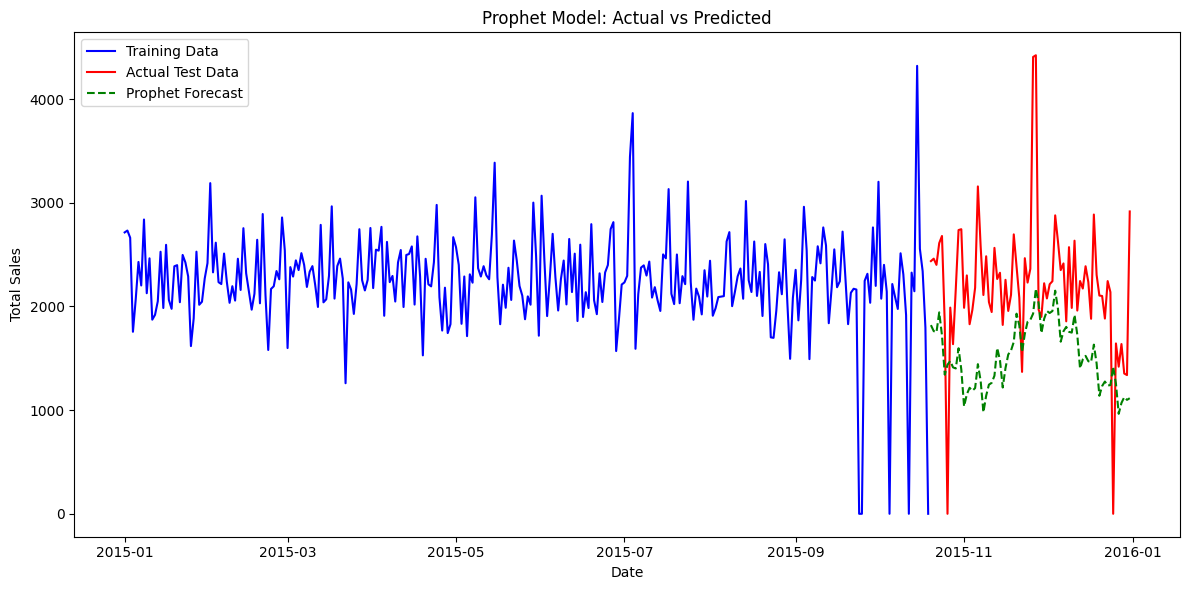

In [22]:
#Plot to visualize the prediction
plt.figure(figsize=(12, 6))
plt.plot(train_data['ds'], train_data['y'], label='Training Data', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Actual Test Data', color='red')
plt.plot(test_data['ds'], prophet_predictions, label='Prophet Forecast', color='green', linestyle='--')
plt.title('Prophet Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()

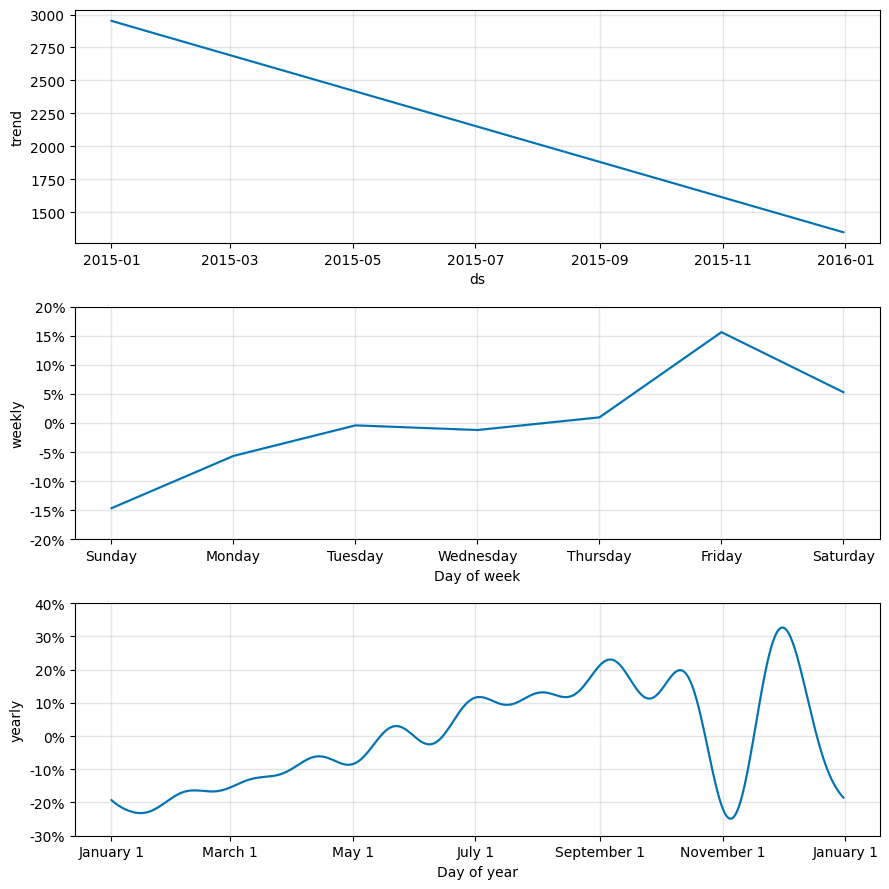

In [23]:
#Trends Generated by Prophet
fig = model_prophet.plot_components(forecast)
plt.tight_layout()
plt.show()

In [24]:
#Prophet performance metrics
prophet_rmse = np.sqrt(mean_squared_error(test_data['y'].values, prophet_predictions))
prophet_mae = mean_absolute_error(test_data['y'].values, prophet_predictions)
prophet_r2 = r2_score(test_data['y'].values, prophet_predictions)
    
print(f"Root Mean Square Error (RMSE): {prophet_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {prophet_mae:.2f}")
print(f"R² Score: {prophet_r2:.4f}")

Root Mean Square Error (RMSE): 891.99
Mean Absolute Error (MAE): 760.78
R² Score: -0.9725


2. LSTM

In [25]:
#Normalize and reshape data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(train_data['y'].values.reshape(-1, 1))

In [26]:
#Creating sequences for LSTM and reshaping the Input
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)
    
seq_length = 7
X_train, y_train = create_sequences(scaled_data, seq_length)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [27]:
#Building the model, optimzer is Adam
model_LSTM = Sequential()
model_LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(units=50))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(units=1))
model_LSTM.compile(optimizer='adam', loss='mean_squared_error')

2025-05-09 00:12:15.546466: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
#Training the model
history = model_LSTM.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

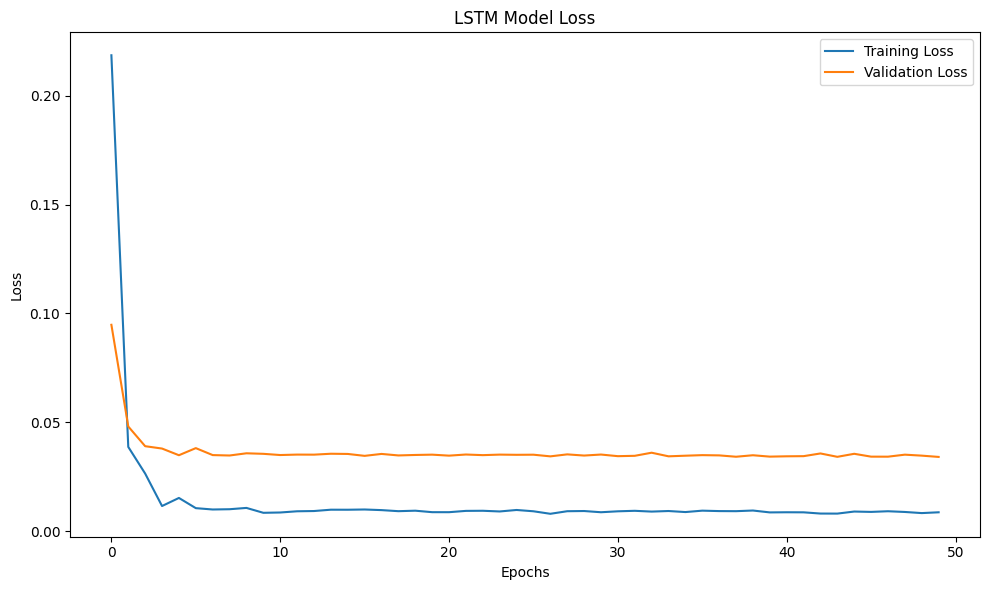

In [29]:
#Plotting the Training
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
#Preparing the test data
inputs = np.concatenate((scaled_data, scaler.transform(test_data['y'].values.reshape(-1, 1))))
test_inputs = []
    
for i in range(len(train_data) - seq_length, len(train_data) + len(test_data) - seq_length):
    test_inputs.append(inputs[i:i + seq_length, 0])
    
test_inputs = np.array(test_inputs)
test_inputs = np.reshape(test_inputs, (test_inputs.shape[0], test_inputs.shape[1], 1))

In [31]:
#Making Predictions
LSTM_predictions = model_LSTM.predict(test_inputs)
LSTM_predictions = scaler.inverse_transform(LSTM_predictions)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


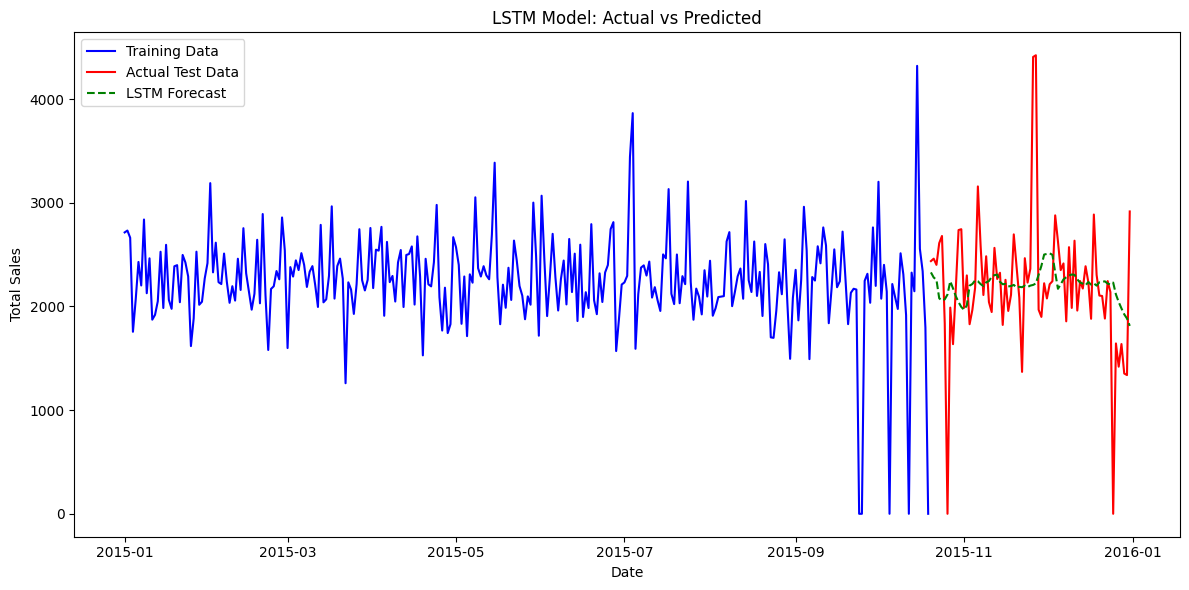

In [32]:
#Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(train_data['ds'], train_data['y'], label='Training Data', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Actual Test Data', color='red')
plt.plot(test_data['ds'], LSTM_predictions, label='LSTM Forecast', color='green', linestyle='--')
plt.title('LSTM Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
#LSTM performance metrics
lstm_rmse = np.sqrt(mean_squared_error(test_data['y'].values, LSTM_predictions.flatten()))
lstm_mae = mean_absolute_error(test_data['y'].values, LSTM_predictions.flatten())
lstm_r2 = r2_score(test_data['y'].values, LSTM_predictions.flatten())
    
print(f"Root Mean Square Error (RMSE): {lstm_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {lstm_mae:.2f}")
print(f"R² Score: {lstm_r2:.4f}")

Root Mean Square Error (RMSE): 634.44
Mean Absolute Error (MAE): 411.36
R² Score: 0.0021


3. SARIMA

In [34]:
'''Setting the parameters for SARIMA
   (p,d,q) for the non-seasonal part and (P,D,Q,s) for the seasonal part
   p,P = AR order, d,D = differencing, q,Q = MA order, s = seasonal length'''
    
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 7)

In [35]:
#Training model
SARIMA_model = SARIMAX(
        train_data['y'],
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
)

results = SARIMA_model.fit(disp=False)
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1508      0.037      4.116      0.000       0.079       0.223
ma.L1         -1.0000      0.038    -26.420      0.000      -1.074      -0.926
ar.S.L7        0.0204      0.090      0.227      0.821      -0.156       0.196
ma.S.L7       -0.7661      0.074    -10.297      0.000      -0.912      -0.620
sigma2      1.827e+05   2.07e-07   8.82e+11      0.000    1.83e+05    1.83e+05


In [36]:
#Making Predictions and Calculating Confidence Intervals
SARIMA_pred = results.get_forecast(steps=len(test_data))
SARIMA_predicted_mean = SARIMA_pred.predicted_mean
SARIMA_pred_conf = SARIMA_pred.conf_int()

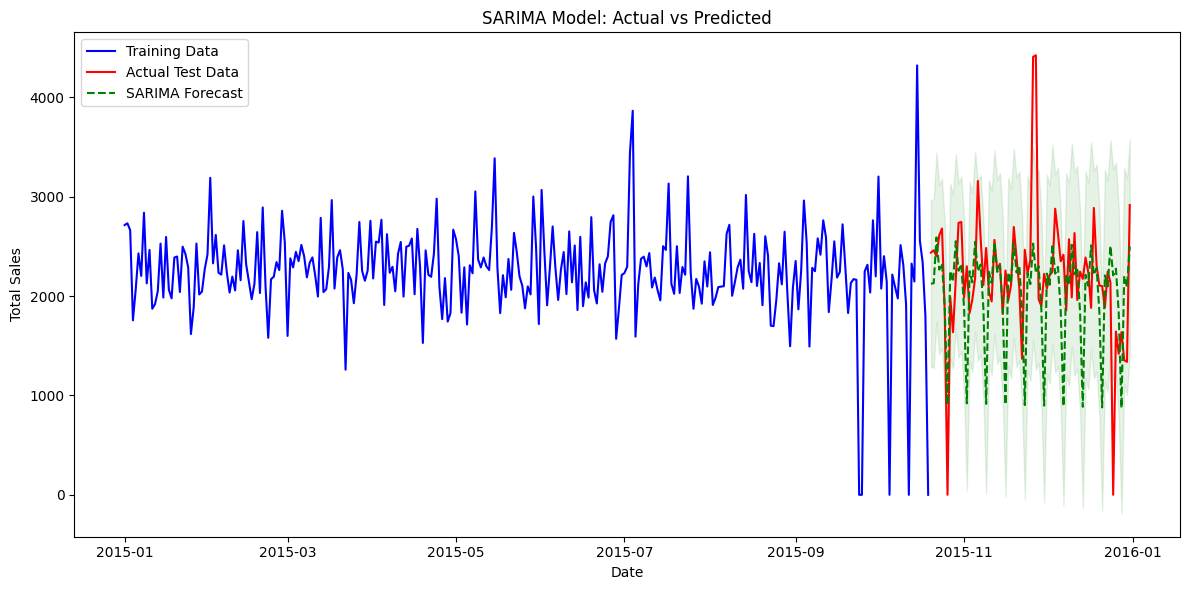

In [37]:
#Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(train_data['ds'], train_data['y'], label='Training Data', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Actual Test Data', color='red')
plt.plot(test_data['ds'], SARIMA_predicted_mean, label='SARIMA Forecast', color='green', linestyle='--')
plt.fill_between(
    test_data['ds'],
    SARIMA_pred_conf.iloc[:, 0],
    SARIMA_pred_conf.iloc[:, 1],
    color='green',
    alpha=0.1
)
plt.title('SARIMA Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
#SARIMA performance metrics
sarima_rmse = np.sqrt(mean_squared_error(test_data['y'].values, SARIMA_predicted_mean))
sarima_mae = mean_absolute_error(test_data['y'].values, SARIMA_predicted_mean)
sarima_r2 = r2_score(test_data['y'].values, SARIMA_predicted_mean)
    
print(f"Root Mean Square Error (RMSE): {sarima_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {sarima_mae:.2f}")
print(f"R² Score: {sarima_r2:.4f}")

Root Mean Square Error (RMSE): 731.21
Mean Absolute Error (MAE): 520.81
R² Score: -0.3255


4. XGBoost Regression

In [39]:
#Feature Engineering for the model
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['month'] = df['ds'].dt.month
    df['dayofmonth'] = df['ds'].dt.day
    df['weekofyear'] = df['ds'].dt.isocalendar().week
        
    for lag in [1, 7, 14]:
        df[f'lag_{lag}'] = df['y'].shift(lag)

    for window in [7, 14, 30]:
        df[f'rolling_mean_{window}'] = df['y'].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df['y'].rolling(window=window).std()
            
    return df
    
full_data = pd.concat([train_data, test_data])
full_data = create_features(full_data)
    
train_features = full_data[:len(train_data)].dropna()
test_features = full_data[len(train_data):].reset_index(drop=True)

In [40]:
#Defining the features and target
feature_columns = [col for col in train_features.columns if col not in ['ds', 'y']]
    
X_train = train_features[feature_columns]
y_train = train_features['y']
X_test = test_features[feature_columns]
y_test = test_features['y']

In [41]:
#Training the model and Predicting
XGBoost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
    
XGBoost_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse',
    early_stopping_rounds=20,
    verbose=False
)

XGBoost_predictions = XGBoost_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


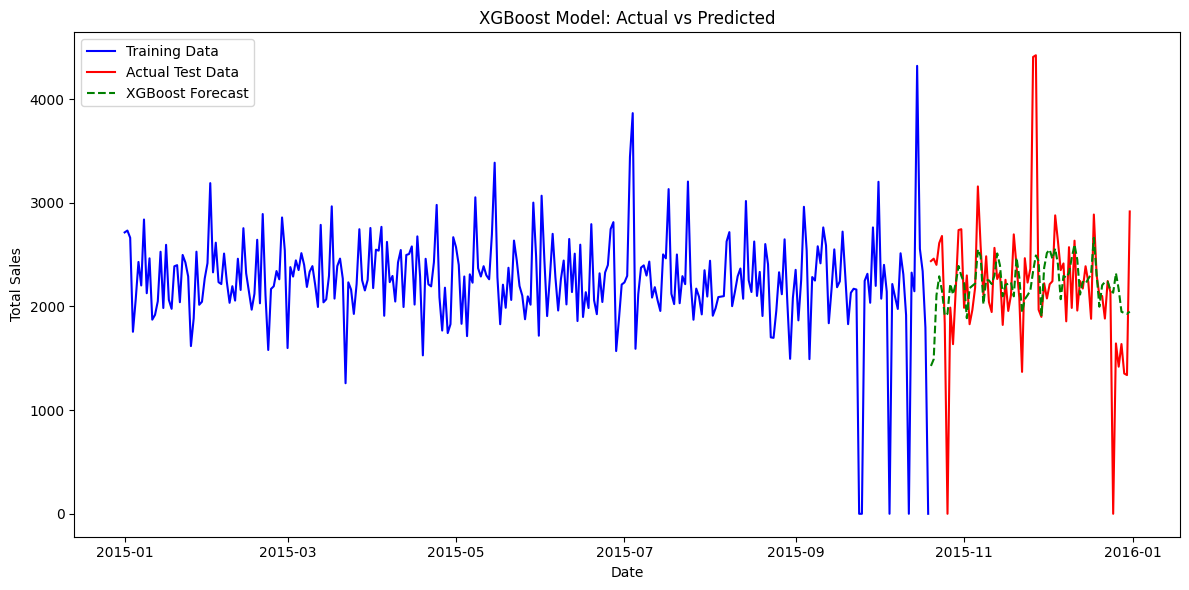

In [42]:
#Plotting the Predictions
plt.figure(figsize=(12, 6))
plt.plot(train_data['ds'], train_data['y'], label='Training Data', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Actual Test Data', color='red')
plt.plot(test_data['ds'], XGBoost_predictions, label='XGBoost Forecast', color='green', linestyle='--')
plt.title('XGBoost Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

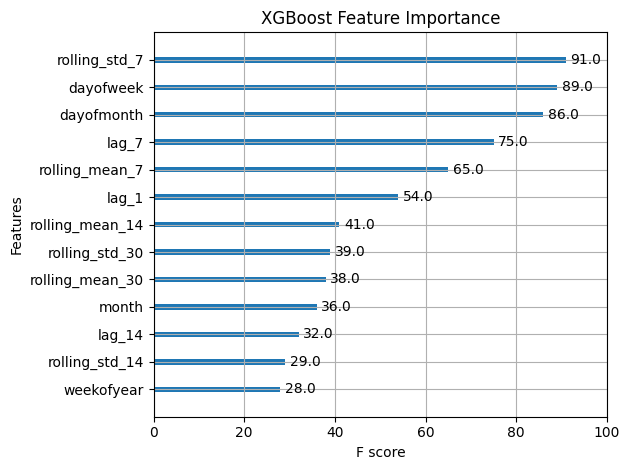

In [43]:
#Plotting the feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(XGBoost_model, max_num_features=15)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

In [44]:
#XGBoost Regression performance metrics
xgb_rmse = np.sqrt(mean_squared_error(y_test, XGBoost_predictions))
xgb_mae = mean_absolute_error(y_test, XGBoost_predictions)
xgb_r2 = r2_score(y_test, XGBoost_predictions)
    
print(f"Root Mean Square Error (RMSE): {xgb_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {xgb_mae:.2f}")
print(f"R² Score: {xgb_r2:.4f}")

Root Mean Square Error (RMSE): 599.51
Mean Absolute Error (MAE): 394.73
R² Score: 0.1090


# Model Performance

In [45]:
#Performance Metrics
metrics_df = pd.DataFrame({
    'Model': ['Prophet', 'LSTM', 'SARIMA', 'XGBoost'],
    'RMSE': [prophet_rmse, lstm_rmse, sarima_rmse, xgb_rmse],
    'MAE': [prophet_mae, lstm_mae, sarima_mae, xgb_mae],
    'R²': [prophet_r2, lstm_r2, sarima_r2, xgb_r2]
})

print(metrics_df)

     Model        RMSE         MAE        R²
0  Prophet  891.989851  760.778870 -0.972519
1     LSTM  634.435630  411.364835  0.002124
2   SARIMA  731.213103  520.805168 -0.325529
3  XGBoost  599.514004  394.726843  0.108954


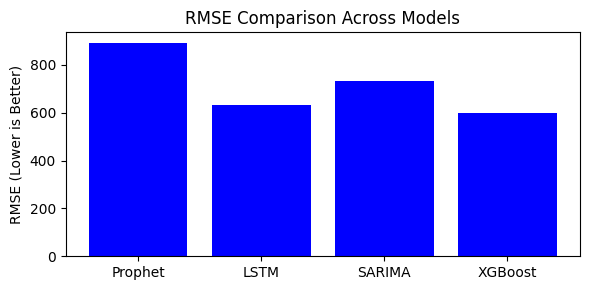

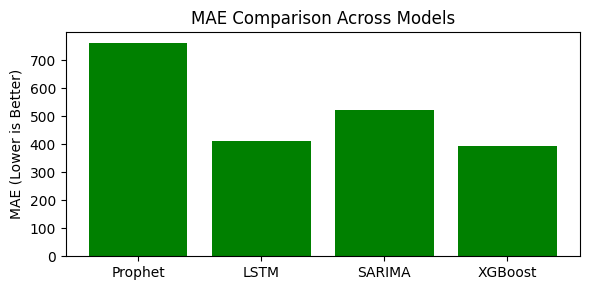

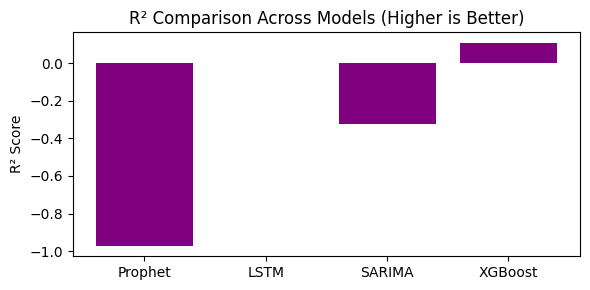

In [46]:
#Plotting the metrics
plt.figure(figsize=(6, 3))
plt.bar(metrics_df['Model'], metrics_df['RMSE'], color='blue')
plt.title('RMSE Comparison Across Models')
plt.ylabel('RMSE (Lower is Better)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.bar(metrics_df['Model'], metrics_df['MAE'], color='green')
plt.title('MAE Comparison Across Models')
plt.ylabel('MAE (Lower is Better)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.bar(metrics_df['Model'], metrics_df['R²'], color='purple')
plt.title('R² Comparison Across Models (Higher is Better)')
plt.ylabel('R² Score')
plt.tight_layout()
plt.show()

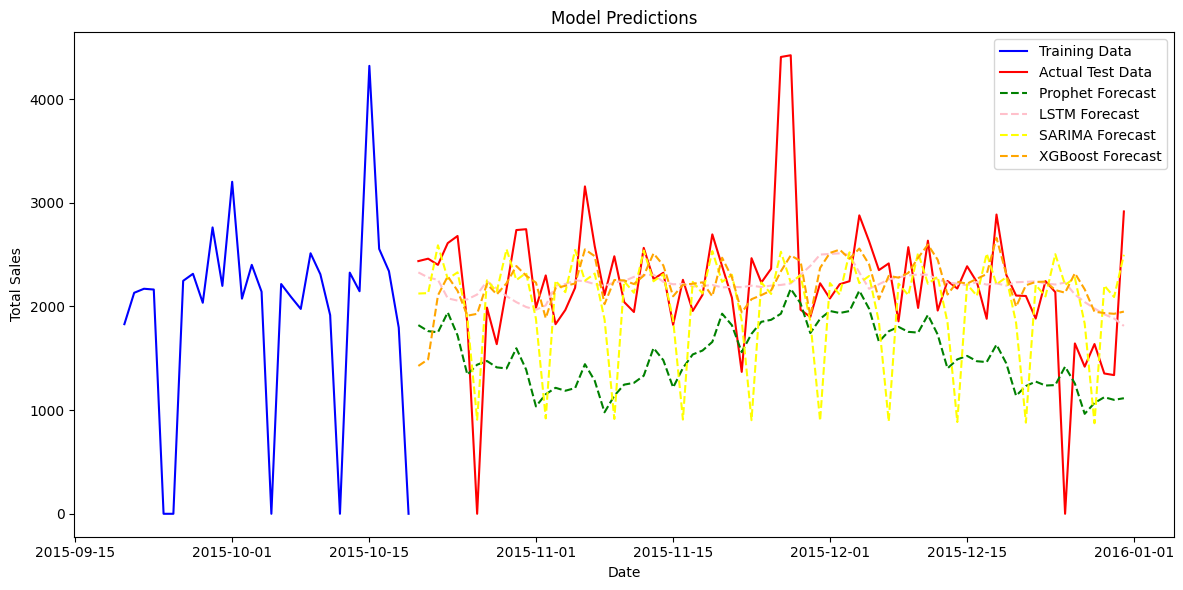

In [47]:
#Predictions plot overlaps
plt.figure(figsize=(12, 6))
plt.plot(train_data['ds'][-30:], train_data['y'][-30:], label='Training Data', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Actual Test Data', color='red')
plt.plot(test_data['ds'], prophet_predictions, label='Prophet Forecast', color='green', linestyle='--')
plt.plot(test_data['ds'], LSTM_predictions, label='LSTM Forecast', color='pink', linestyle='--')
plt.plot(test_data['ds'], SARIMA_predicted_mean, label='SARIMA Forecast', color='yellow', linestyle='--')
plt.plot(test_data['ds'], XGBoost_predictions, label='XGBoost Forecast', color='orange', linestyle='--')
plt.title('Model Predictions')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()

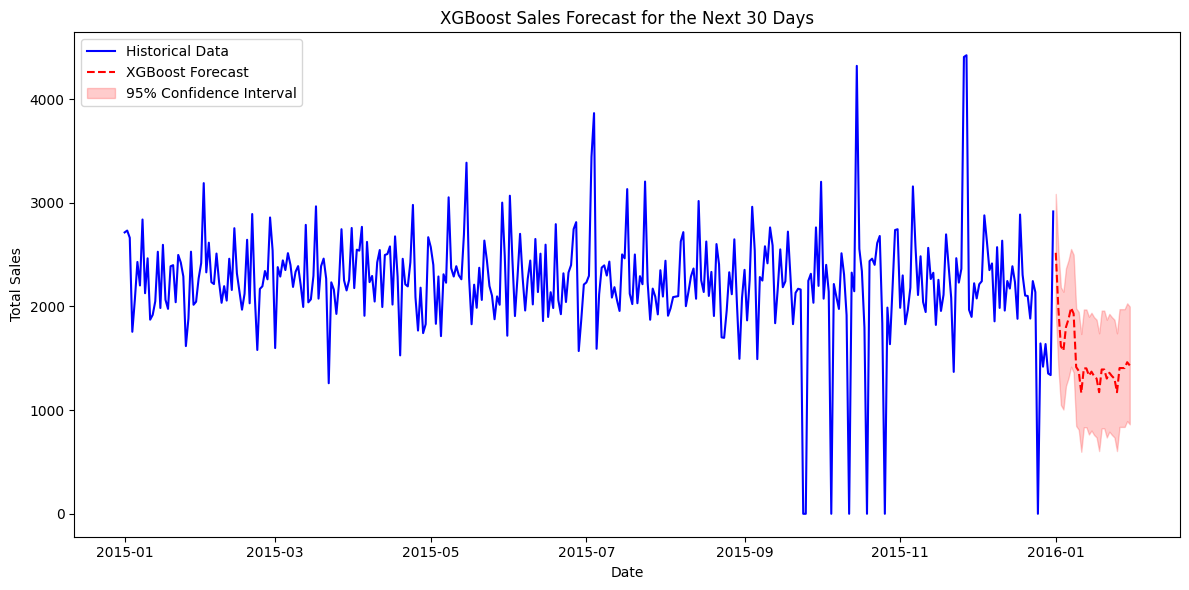

Summary of Forecasted Values:
              yhat   yhat_lower   yhat_upper
count    30.000000    30.000000    30.000000
mean   1497.572909   929.632814  2065.513003
std     299.779485   299.779485   299.779485
min    1166.011353   598.071258  1733.951447
25%    1329.842987   761.902892  1897.783082
50%    1402.677246   834.737151  1970.617341
75%    1545.883179   977.943084  2113.823274
max    2517.250977  1949.310882  3085.191071


In [48]:
#Predicting the next 30 days of sales using the the best performing model. (XGBoost)
days=30
last_date = daily_sales['ds'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days)
future_df = pd.DataFrame({'ds': future_dates})
    
extended_df = pd.concat([daily_sales, future_df])
extended_features = create_features(extended_df)
    
# For future dates, we need to recursively predict and fill in values
# This is because lag features depend on previous predictions
for i in range(len(daily_sales), len(extended_features)):
    # Get features for this date
    date_features = extended_features.iloc[i:i+1][feature_columns]
    pred = XGBoost_model.predict(date_features)[0]
    # Update the y value with our prediction (needed for next day's lag features)
    extended_features.iloc[i, extended_features.columns.get_loc('y')] = pred
    
    # Update lag features and rolling statistics for the next prediction
    if i + 1 < len(extended_features):
        if 'lag_1' in extended_features.columns:
            extended_features.iloc[i+1, extended_features.columns.get_loc('lag_1')] = pred
            
        for lag in [7, 14]:
            if i + lag < len(extended_features) and f'lag_{lag}' in extended_features.columns:
                idx = i + lag
                col = extended_features.columns.get_loc(f'lag_{lag}')
                extended_features.iloc[idx, col] = pred
            
        for window in [7, 14, 30]:
            if f'rolling_mean_{window}' in extended_features.columns:
                # Get recent values including our new prediction
                recent_vals = extended_features['y'].iloc[max(0, i-window+1):i+1]
                mean_val = recent_vals.mean()
                std_val = recent_vals.std()
                    
                # Update for next prediction if needed
                if i + 1 < len(extended_features):
                    extended_features.iloc[i+1, extended_features.columns.get_loc(f'rolling_mean_{window}')] = mean_val
                    extended_features.iloc[i+1, extended_features.columns.get_loc(f'rolling_std_{window}')] = std_val
    
# Extract future predictions
future_predictions = extended_features.iloc[-days:][['ds', 'y']]
future_predictions.columns = ['ds', 'yhat']

# Generate confidence intervals (approximate)
train_preds = XGBoost_model.predict(X_train)
residuals = y_train - train_preds
std_residuals = residuals.std()
    
# Create 95% confidence intervals (±1.96 standard deviations)
future_predictions['yhat_lower'] = future_predictions['yhat'] - 1.96 * std_residuals
future_predictions['yhat_upper'] = future_predictions['yhat'] + 1.96 * std_residuals
    
# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['ds'], daily_sales['y'], label='Historical Data', color='blue')
plt.plot(future_predictions['ds'], future_predictions['yhat'], label='XGBoost Forecast', color='red', linestyle='--')
plt.fill_between(
    future_predictions['ds'],
    future_predictions['yhat_lower'],
    future_predictions['yhat_upper'],
    color='red',
    alpha=0.2,
    label='95% Confidence Interval'
)
plt.title(f'XGBoost Sales Forecast for the Next {days} Days')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()
    
print("Summary of Forecasted Values:")
print(future_predictions[['yhat', 'yhat_lower', 'yhat_upper']].describe())